In [63]:
from pathlib import Path
import numpy as np
import pandas as pd
import math
from numba import njit,jit
import time
from matplotlib import pyplot as plt
import yaml
import networkx as nx
import scipy

# Define paths
path_prefix = Path("/Users/saadjansari/Documents/Projects/Results/AMSOS")
simpath = {
    'Tac': path_prefix / "Tactoids/scan_filamin_6400/run/f5_merged",
#     'Tac': path_prefix / "Tactoids/n25600/f5",
}

# resolve paths
for key in simpath.keys():
    simpath[key].resolve()

### How many proteins on a filament?

In [64]:
def get_volume_from_config(spath, conf=False):
    # Read yaml config file to extract information about space
    # If confinement is True, use a cylindrical confinement in XY plane, but full box size in Z
    with open( spath / 'RunConfig.yaml') as yf:
        rconfig = yaml.safe_load( yf)
        
    box_size = np.array( rconfig['simBoxHigh']) - np.array( rconfig['simBoxLow'])
    
    if conf:
        cyl_length = box_size[ np.array( rconfig['boundaries'][0]['axis'], dtype=bool)]
        cyl_rad = rconfig['boundaries'][0]['radius']
        vol = math.pi * cyl_rad**2 * cyl_length
        vol = vol[0]
    else:
        vol = boxsize[0]*boxsize[1]*boxsize[2]
    
    return vol

def get_boxsize_pbc(spath, conf=False):
    # Read yaml config file to extract information about space
    # If confinement is True, use a cylindrical confinement in XY plane, but full box size in Z
    with open( spath / 'RunConfig.yaml') as yf:
        rconfig = yaml.safe_load( yf)
        
    box_size = np.array( rconfig['simBoxHigh']) - np.array( rconfig['simBoxLow'])
    if conf:
        box_size[0] = 2*box_size[0]
        box_size[1] = 2*box_size[1]
    return box_size
    
def find_last_n_frames(spath,n=1):
    
    def fileKey(f):
        return int( f.parts[-1].split('_')[-1].split('.dat')[0] )
    file_s_last = sorted( list(spath.glob('**/SylinderAscii*')), key=fileKey)[-n:]
    file_p_last = sorted( list(spath.glob('**/ProteinAscii*')), key=fileKey)[-n:]
    return file_s_last, file_p_last

@njit
def unfold_trajectories(crds, boxsize):
    # unfolded trajectory via the shortest route
    # expect input: crds = [time, particle, dim]
    crds2 = np.zeros_like(crds)
    crds2[0,:,:] = crds[0,:,:]
    for idx in np.arange(crds.shape[-1]):
        for ipart in np.arange(crds.shape[1]):
            
            # find amount particle travels frame to frame
            dist = nb_diff( crds[:,ipart,idx])
            k = np.sign( dist) * np.floor( np.absolute(dist)/(0.51*boxsize[idx]))
            dist -= k*boxsize[idx]
            crds2[1:,ipart,idx] = dist.cumsum()+crds[0,ipart,idx]
    return crds2

@njit
def nb_diff(x):
    return x[1:] - x[:-1]

def find_frames(spath):
    
    def fileKey(f):
        return int( f.parts[-1].split('_')[-1].split('.dat')[0] )
    file_s_last = sorted( list(spath.glob('**/SylinderAscii*')), key=fileKey)
    file_p_last = sorted( list(spath.glob('**/ProteinAscii*')), key=fileKey)
    return file_s_last, file_p_last

def get_edges_in_largest_cc( cc, edge0, edge1):

    # initialize
    idx_edges = []
    n_edges = 0

    # num xlinks in biggest cluster
    for idx in np.arange(len(edge0)):
        if edge0[idx] in cc and edge1[idx] in cc:
            idx_edges.append( idx)
            n_edges+=1

    return idx_edges, n_edges

def get_largest_cc( nodes, edge0, edge1):
    # Get largesst connected component
    # nodes is a list of integers representing node indices
    # edge0 / edge1 are the list of nodes that each edge connects to.
    # Indices whose values are -1 are ignored in both edge0 and edge1.

    # Create a graph for filaments
    g = nx.Graph()
    g.add_nodes_from( nodes)

    # add edges to the graph
    for e0,e1 in zip( edge0,edge1):
        if e0 != -1 and e1 != -1:
            g.add_edge(e0, e1)

    # find connected component largest
    cc = list( max(nx.connected_components(g), key=len) )

    # also get a boolean array representing nodes that are in the largest cc
    cc_bool = np.zeros(len(nodes), dtype=bool)
    cc_bool[ cc] = True
    return cc, cc_bool

def read_dat_sylinder( fname):
    # Read a SylinderAscii_X.dat file

    # open the file and read the lines
    with open(fname, 'r') as file1:
        filecontent = file1.readlines()

        # Initialize numpy arrays for data
        gids = np.zeros( len(filecontent)-2, dtype=int)
        rad = np.zeros(len(filecontent)-2)
        pos0 = np.zeros( (len(filecontent)-2,3))
        pos1 = np.zeros( (len(filecontent)-2,3))
        ort = np.zeros( (len(filecontent)-2,3))

        # Delete the first two lines because they dont have any data
        filecontent[0:2] = []
        for idx,line in enumerate(filecontent):

            # Split the string with space-delimited and convert strings into useful data types
            data = line.split()
            gids[idx] = int(data[1])

            dat = np.array( list(map(float,data[2::])) )
            rad[idx] = dat[0]
            pos0[idx,:] = dat[1:4]
            pos1[idx,:] = dat[4::]
            xi = pos1[idx,:] - pos0[idx,:]
            ort[idx,:] =  xi/np.sqrt(xi.dot(xi))

    # Store data as a dataframe
    df = pd.DataFrame({
        'gid': gids,
        'radius' : rad,
        'pos0' : list(pos0),
        'pos1': list(pos1),
        'orientation': list(ort)
        })
    return df

def read_dat_protein( fname):
    # Read a ProetinAscii_X.dat file

    # open the file and read the lines
    with open(fname, 'r') as file1:
        filecontent = file1.readlines()

        # Delete the first two lines because they dont have any data
        filecontent[0:2] = []

        # Initialize numpy arrays for data
        gids = np.zeros( len(filecontent), dtype=int)
        pos0 = np.zeros( (len(filecontent),3))
        pos1 = np.zeros( (len(filecontent),3))
        link0 = np.zeros( len(filecontent), dtype=int)
        link1 = np.zeros( len(filecontent), dtype=int)

        for idx,line in enumerate(filecontent):

            # Split the string with space-delimited and convert strings into useful data types
            data = line.split()
            # pdb.set_trace()
            gids[idx] = int(data[1])
            link0[idx] = int(data[9])
            link1[idx] = int(data[10])
            dat = np.array( list(map(float,data[2:9])) )
            pos0[idx,:] = dat[1:4]
            pos1[idx,:] = dat[4::]

    # Store data as a dataframe
    df = pd.DataFrame({
        'gid': gids,
        'pos0' : list(pos0),
        'pos1': list(pos1),
        'link0': link0,
        'link1': link1
        })
    return df

In [65]:
spath = simpath['Tac']

# Load data
boxsize = get_boxsize_pbc( spath)
    
# get last n frames
syl_frame = find_last_n_frames( spath,n=1)[0][0]
prot_frame = find_last_n_frames( spath,n=1)[1][0]
            
df_sylinder = read_dat_sylinder( syl_frame )
df_protein = read_dat_protein( prot_frame)

# Get proteins in cluster
# Get large clusters
cc = np.array( get_largest_cc( 
    df_sylinder.gid.tolist(), 
    df_protein.link0.tolist(),
    df_protein.link1.tolist())[0])

cc_set = set(cc)
nprot = np.zeros_like(cc)
for idx in np.arange(df_protein.shape[0]):
    L0 = df_protein.link0[idx]
    L1 = df_protein.link1[idx]
    if L0 in cc_set:
        idx2 = np.argwhere( np.array(cc) == L0)[0][0]
        nprot[idx2]+=1
    if L1 in cc_set:
        idx2 = np.argwhere( np.array(cc) == L1)[0][0]
        nprot[idx2]+=1

(array([ 88., 169., 334., 420., 469., 411., 296., 133.,  68.,  19.,   5.]),
 array([ 1.        ,  4.90909091,  8.81818182, 12.72727273, 16.63636364,
        20.54545455, 24.45454545, 28.36363636, 32.27272727, 36.18181818,
        40.09090909, 44.        ]),
 <BarContainer object of 11 artists>)

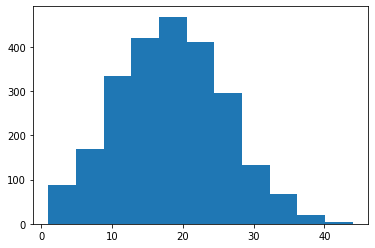

In [70]:
plt.hist( nprot, bins=11)

In [73]:
np.argwhere(nprot==max(nprot))[0][0]

824

In [68]:
df_protein.shape[0]

22400